In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
shap.initjs()
%matplotlib inline
task_name = '08'

In [2]:
try:
    with open(task_name + '.dataset', 'rb') as f:
        X, y, feature_names = pickle.load(f)
    with open(task_name + '.models', 'rb') as f:
        comparer = pickle.load(f)
    with open(task_name + '.expl', 'rb') as f:
        explanations = pickle.load(f)
    print('loaded saved state')
except FileNotFoundError:
    pass

loaded saved state


# Setup Task

In [3]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=0)
X *= 100
feature_names = np.array(['x1', 'x2'])
with open(task_name + '.dataset', 'wb') as f:
    pickle.dump((X, y, feature_names), f, pickle.HIGHEST_PROTOCOL)

In [4]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X, y)
lm.intercept_, lm.coef_

(array([1.11018683]), array([[-0.02146303,  0.02909487]]))

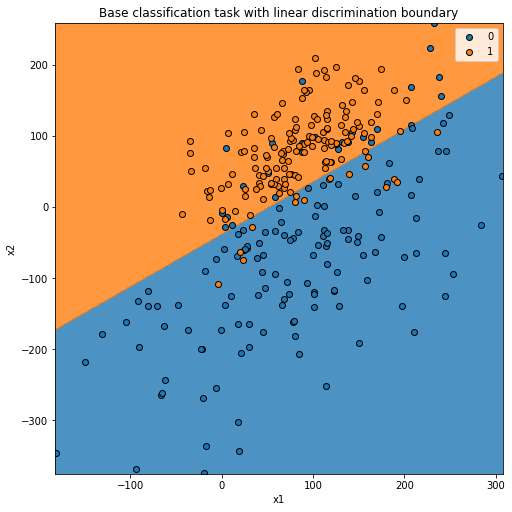

In [5]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=lm.predict, class_names=lm.classes_,
                       fig=fig, ax=ax)

In [6]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf_a = QuadraticDiscriminantAnalysis(store_covariance=True)
clf_a.fit(X, y)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [7]:
from sklearn.naive_bayes import GaussianNB
clf_b = GaussianNB()
clf_b.fit(X, y)

GaussianNB()

In [8]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)
with open(task_name + '.models', 'wb') as f:
    cloudpickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

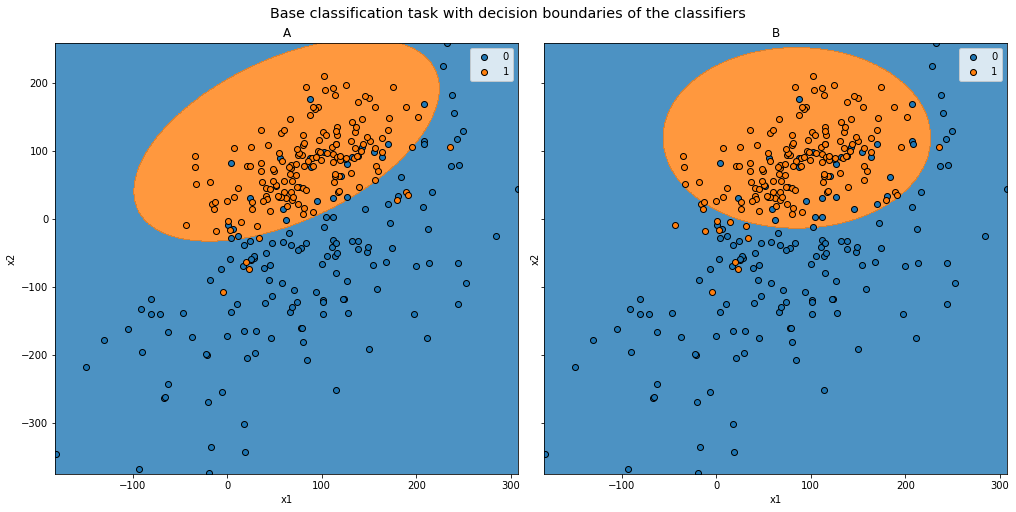

In [9]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

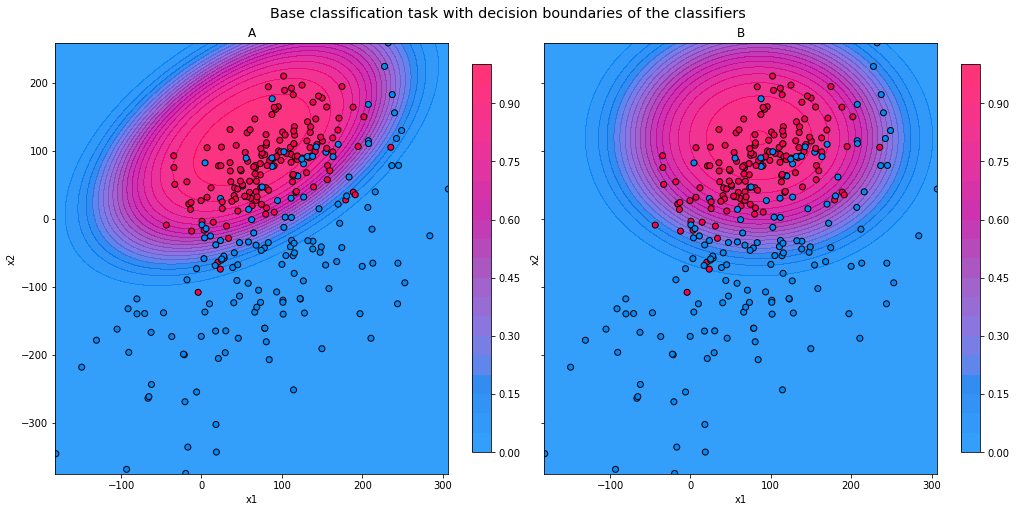

In [10]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='proba')

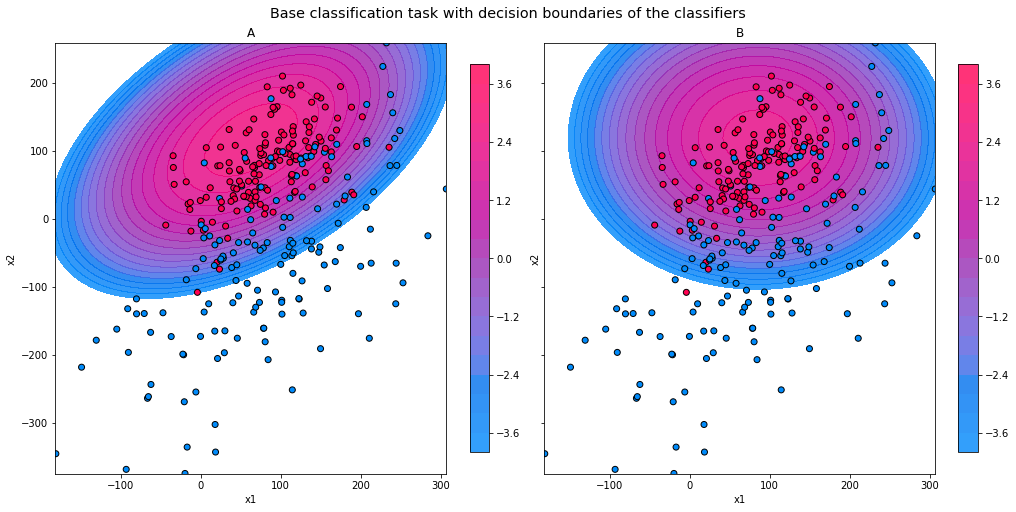

In [91]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='log-odds')

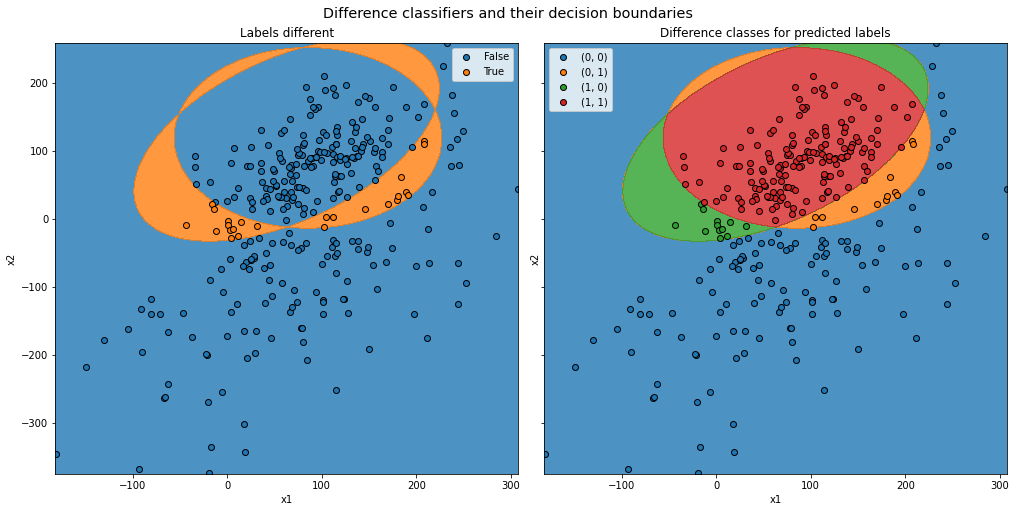

In [10]:
comparer.plot_decision_boundaries(X)

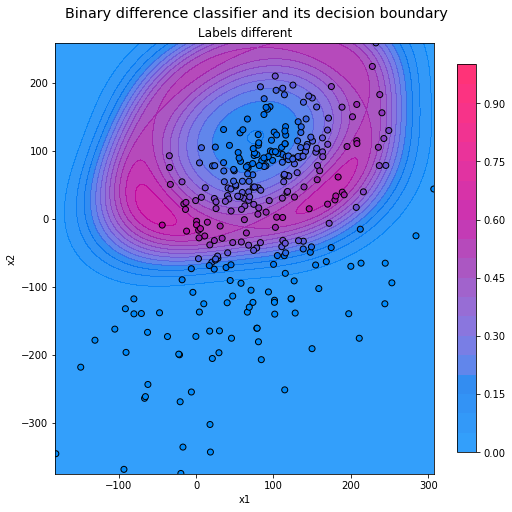

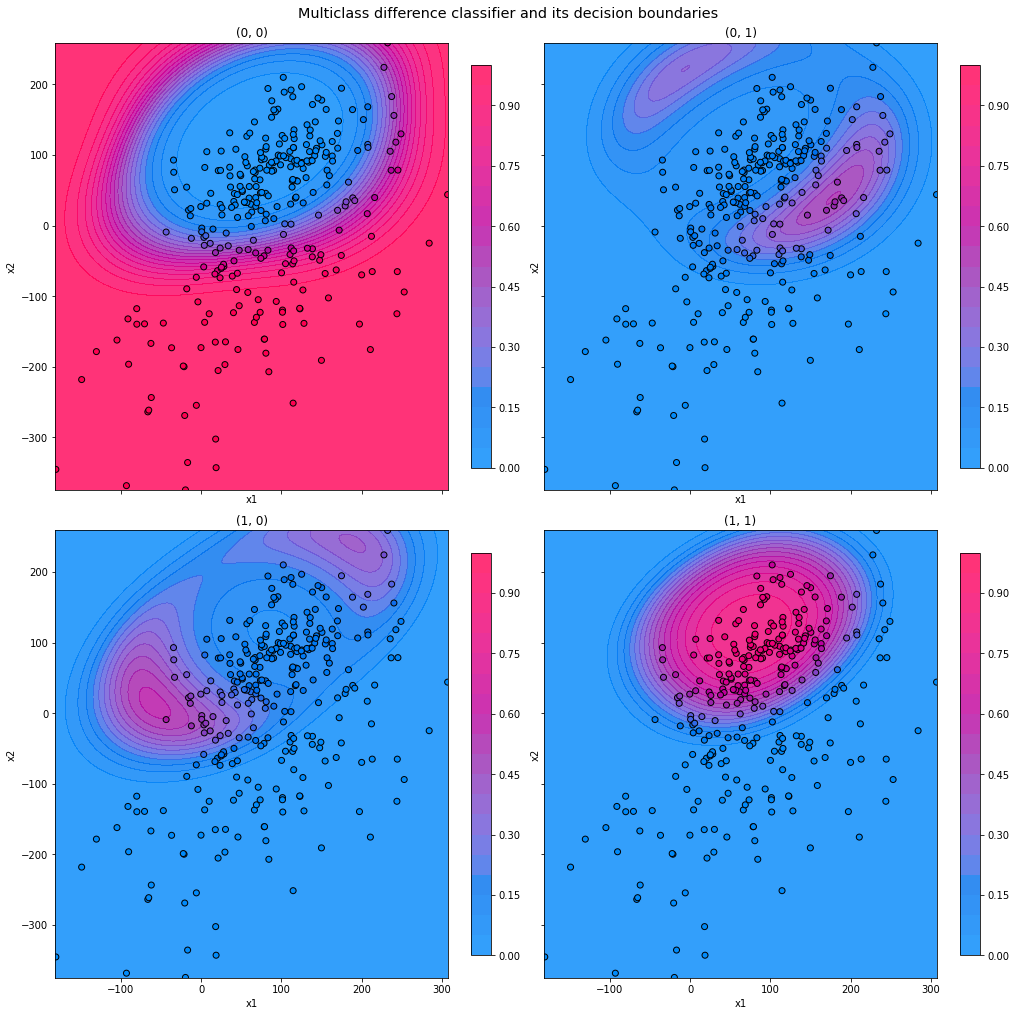

In [11]:
comparer.plot_decision_boundaries(X, kind='proba')

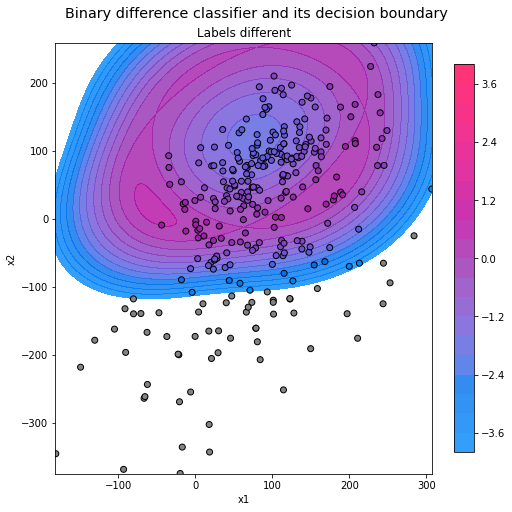

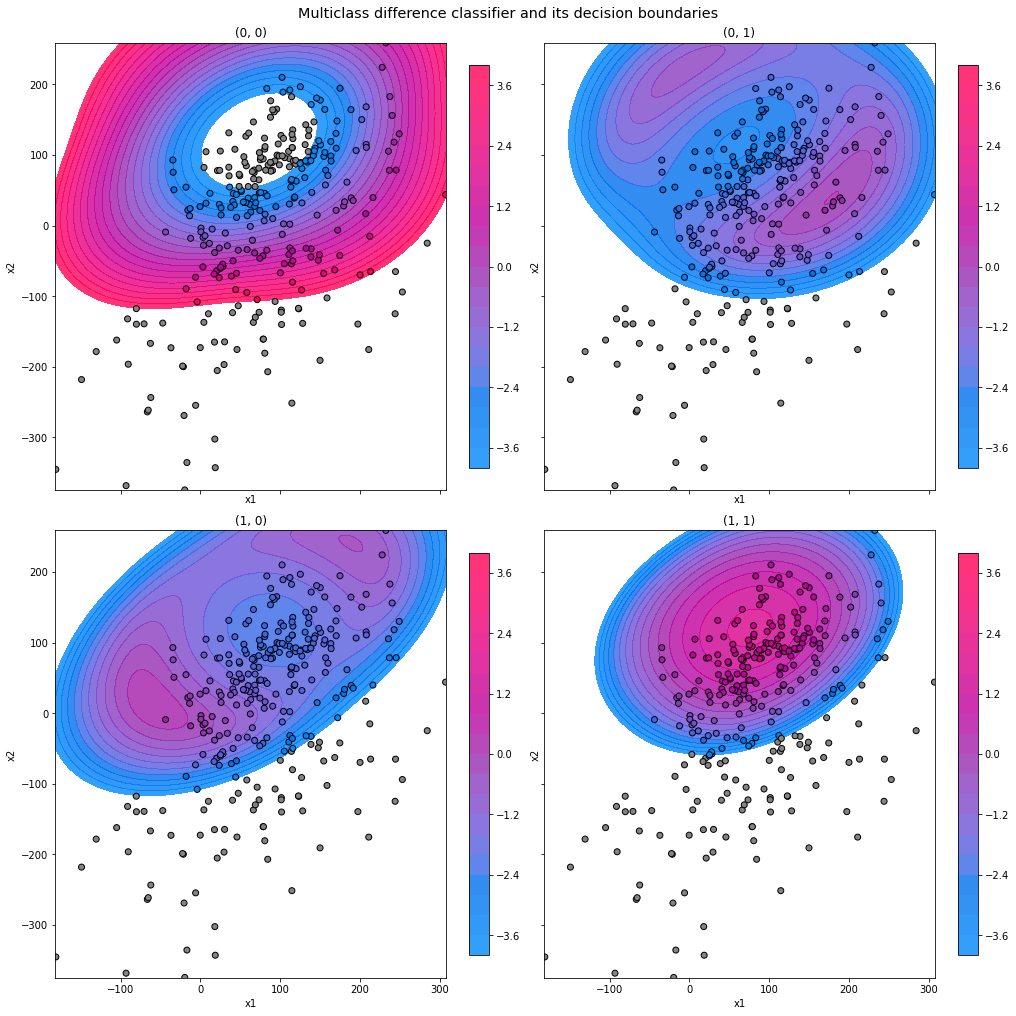

In [92]:
comparer.plot_decision_boundaries(X, kind='log-odds')

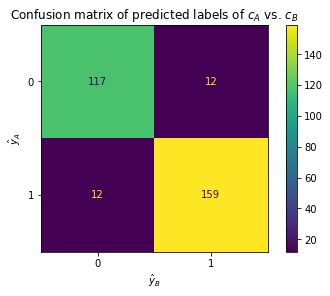

In [11]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [12]:
%%time
explanations = generate_shap_explanations(comparer, X, space_types=['labels', 'proba', 'log_odds'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump(explanations, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 12.3 s, sys: 207 ms, total: 12.5 s
Wall time: 13 s


## Visualize SHAP values

### Individual explanations

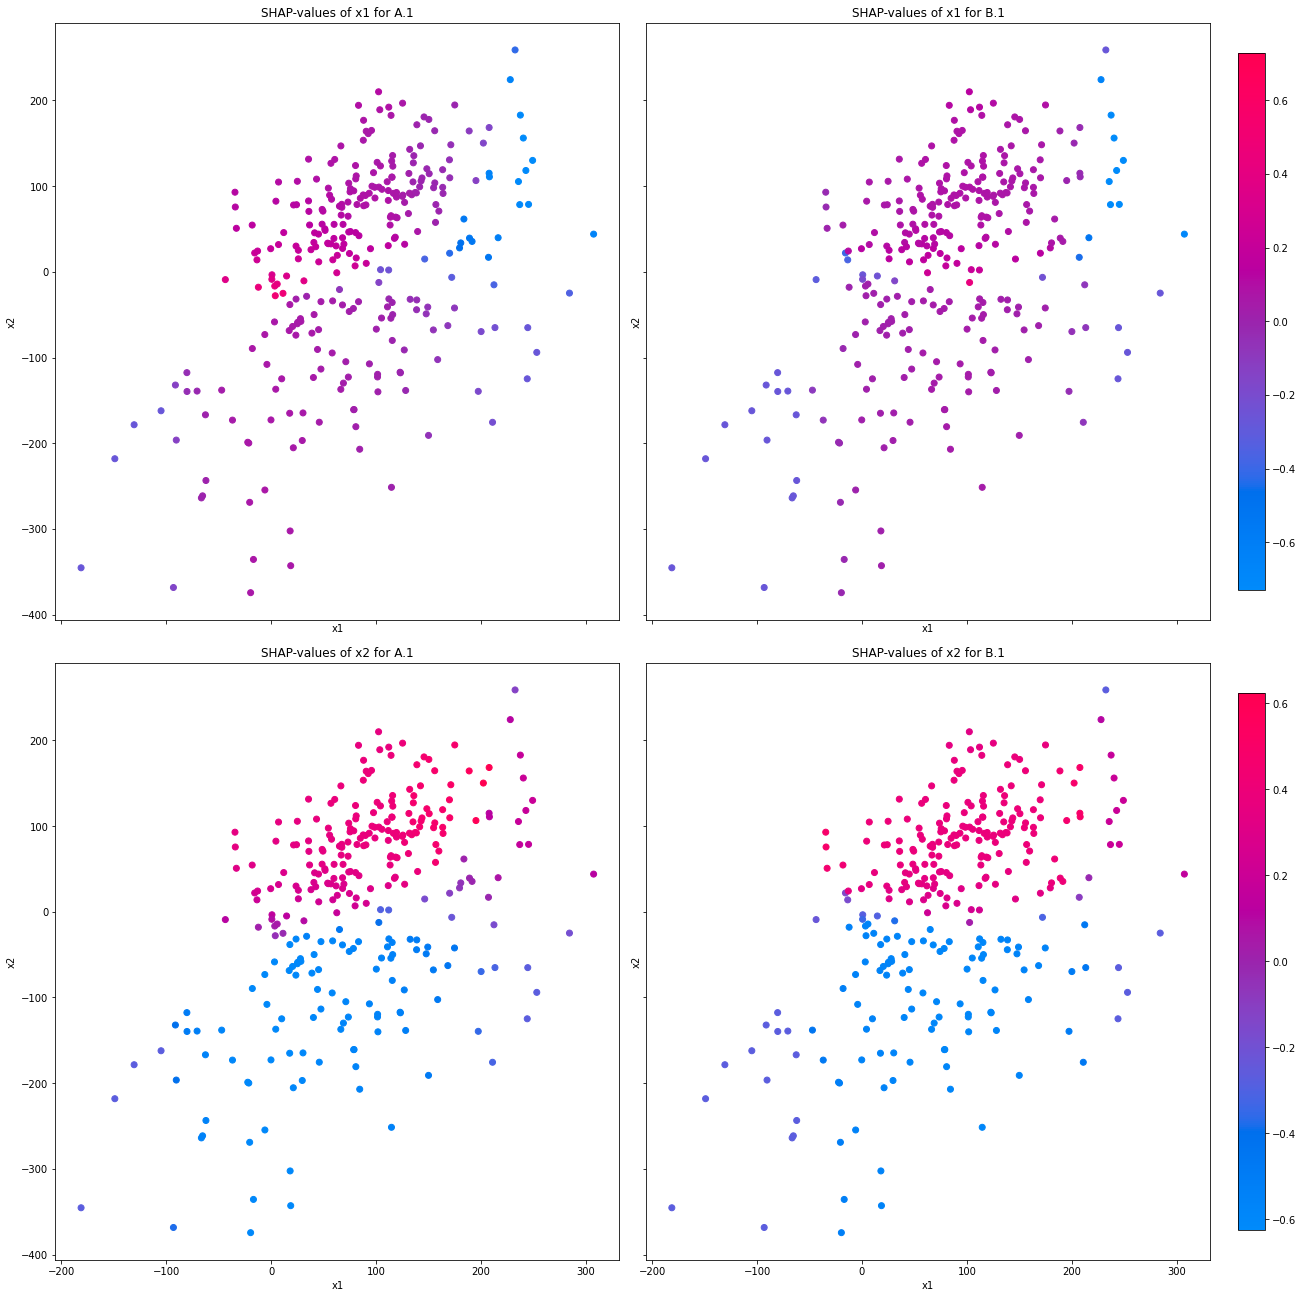

In [13]:
plot_2d(explanations.indiv.labels[:, :, 1].merged)

### Simple subtraction explanation

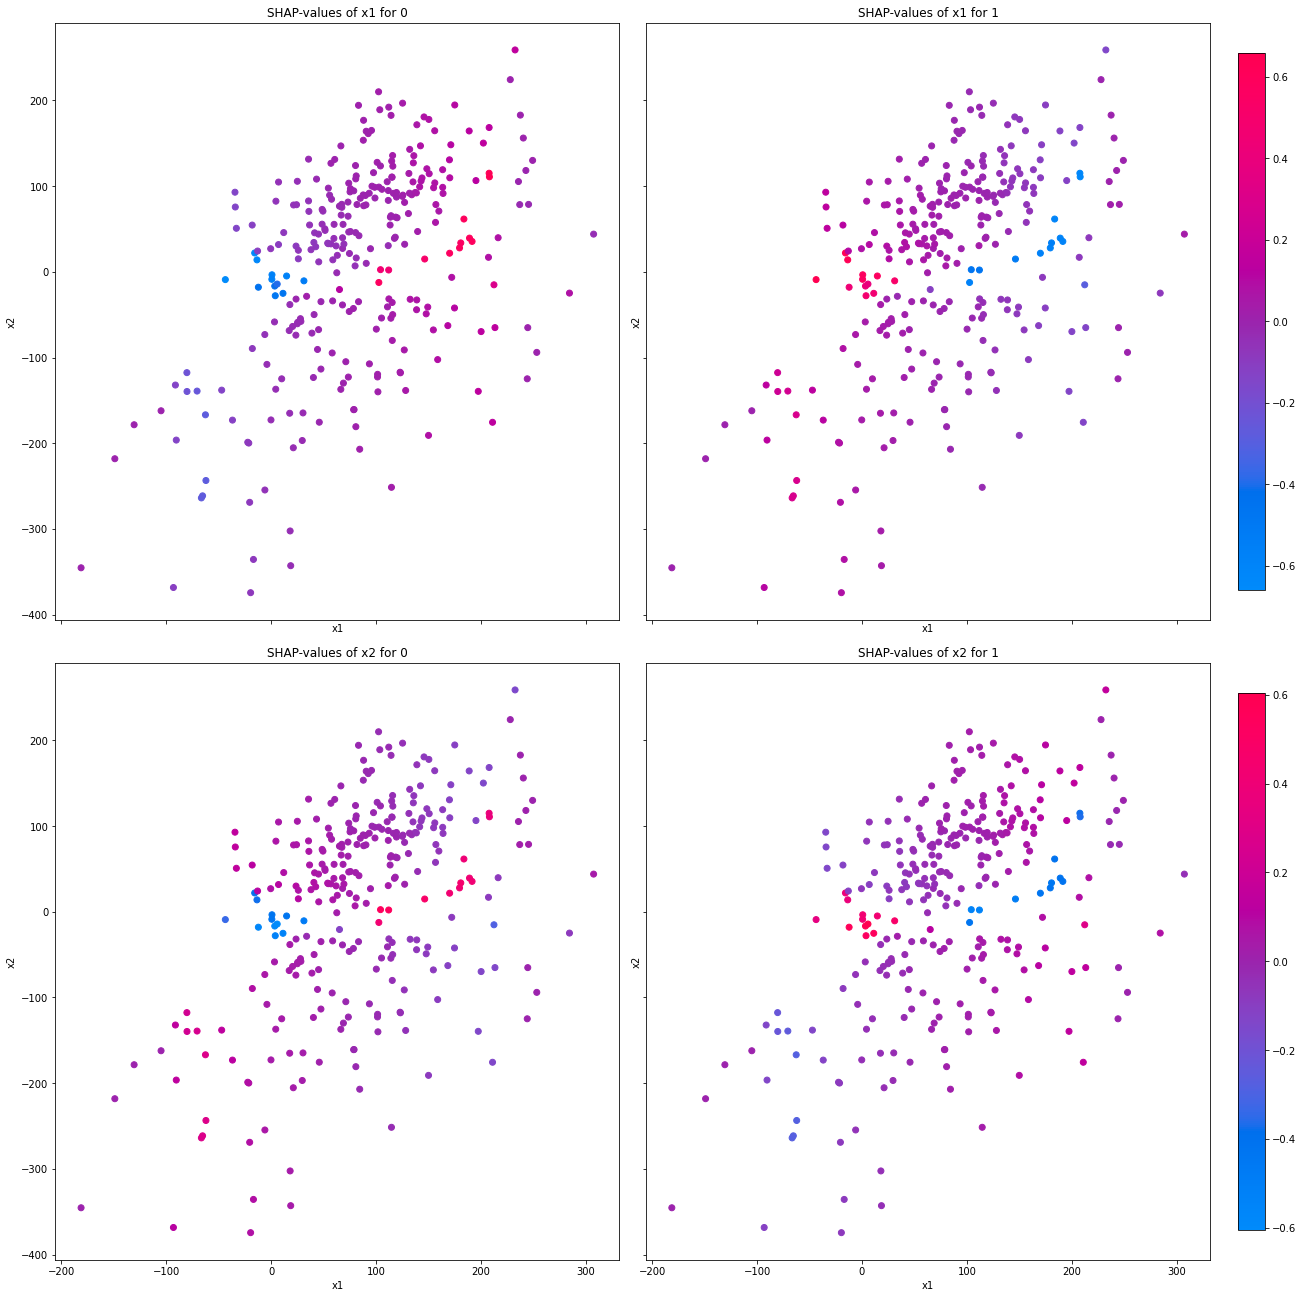

In [14]:
plot_2d(explanations.indiv_diff.labels)

### Multiclass difference classifier explanations

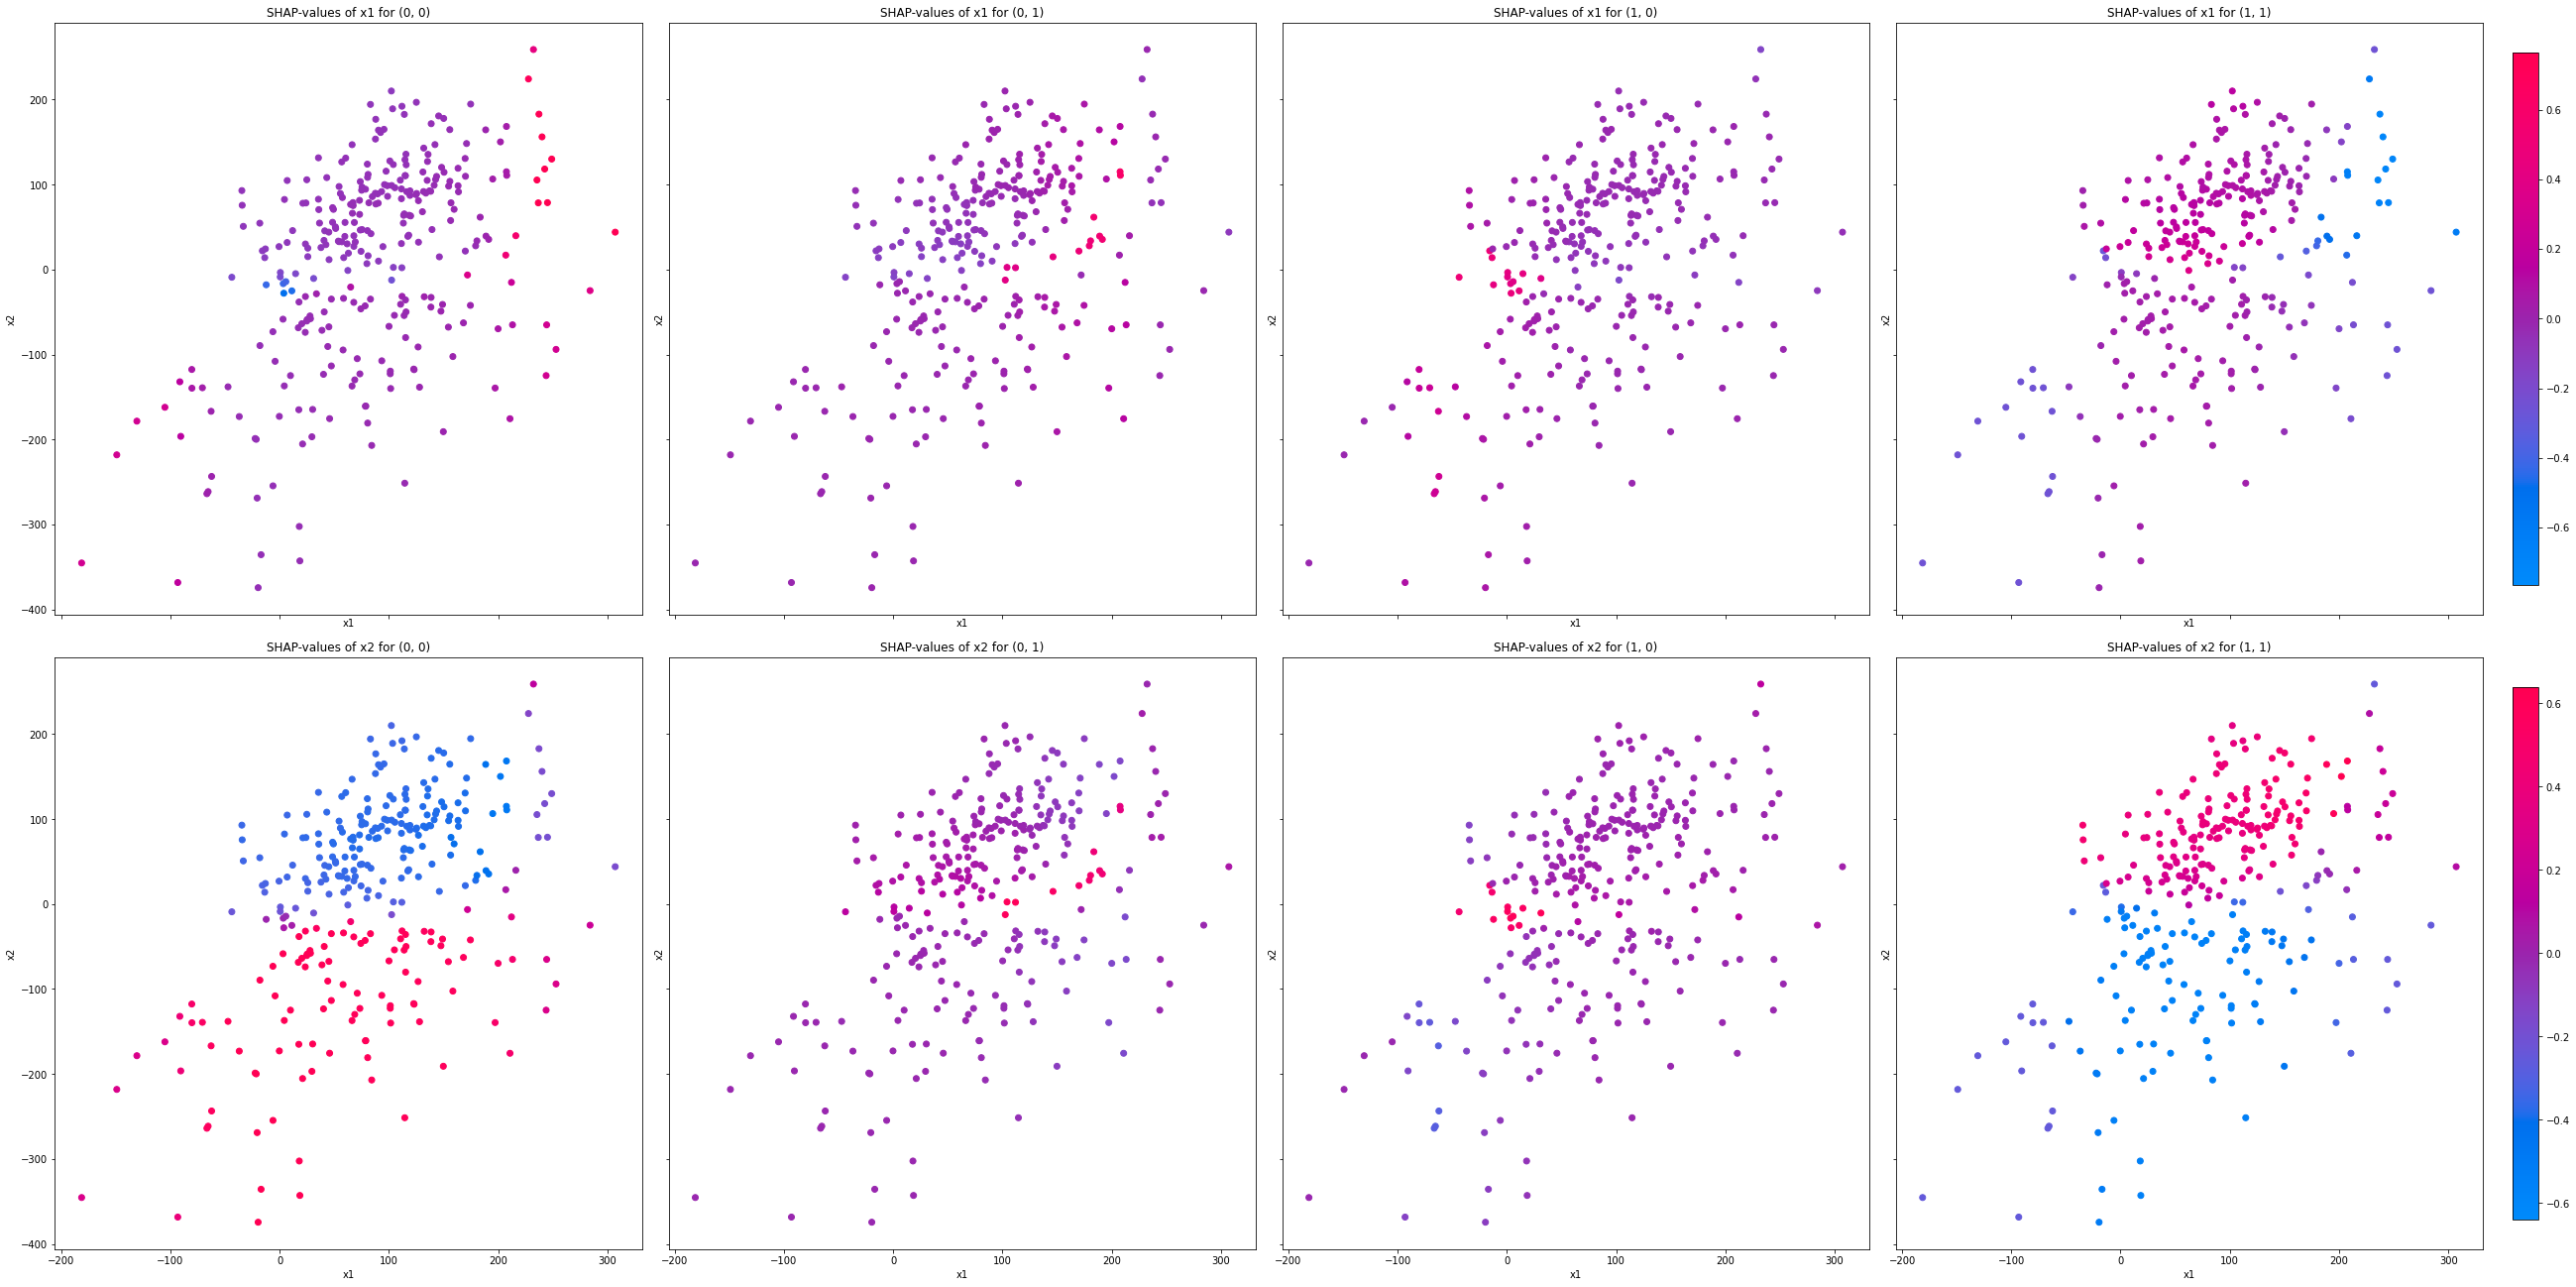

In [15]:
plot_2d(explanations.mclass_diff.labels)

## Feature importance

### Individual explanations

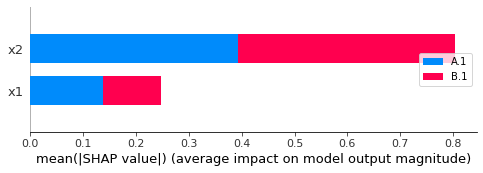

In [16]:
plot_feature_importance_bar(explanations.indiv.labels[:, :, 1].merged)

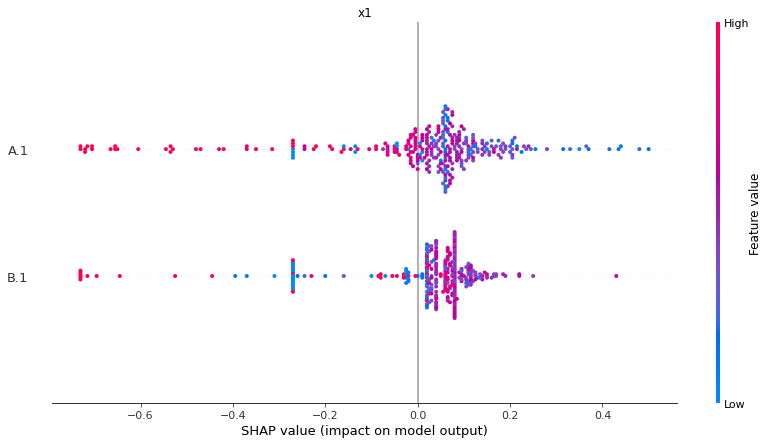

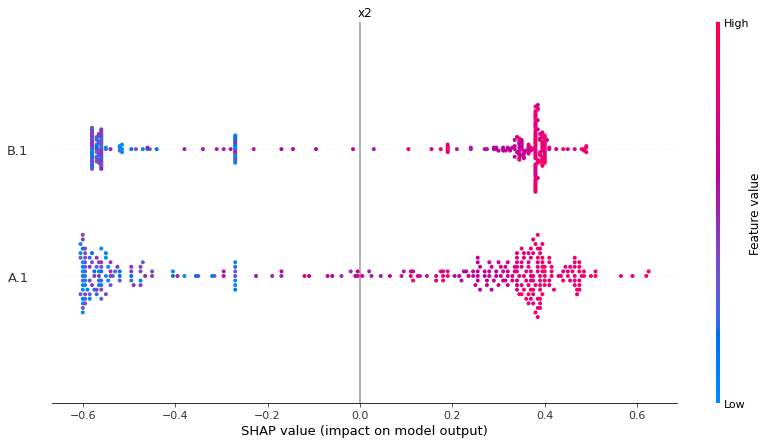

In [17]:
plot_feature_importance_scatter(explanations.indiv.labels[:, :, 1].merged)

### Simple subtraction explanation

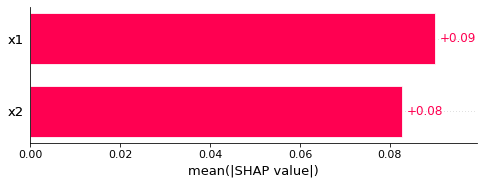

In [18]:
plot_feature_importance_bar(explanations.indiv_diff.labels[:, :, 1])

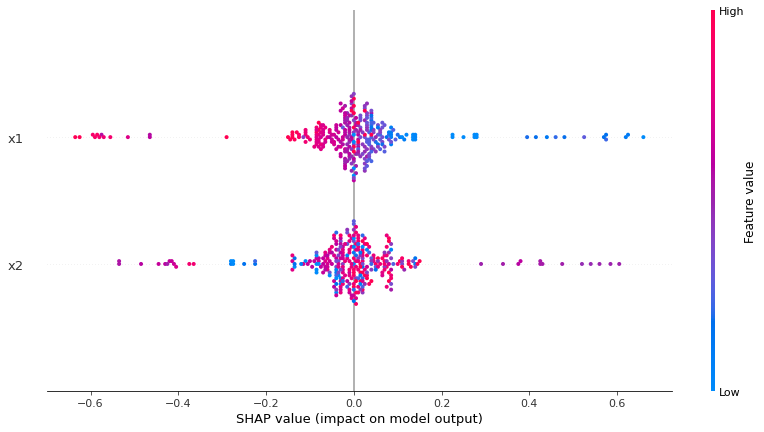

In [19]:
plot_feature_importance_scatter(explanations.indiv_diff.labels[:, :, 1])

### Multiclass difference classifier explanations

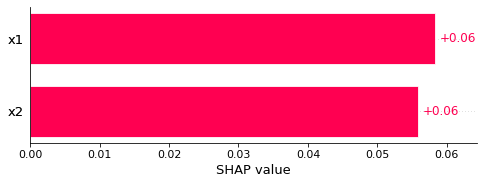

In [20]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.labels[:, :, comparer.difference_class_names])
plot_feature_importance_bar(feature_importance)

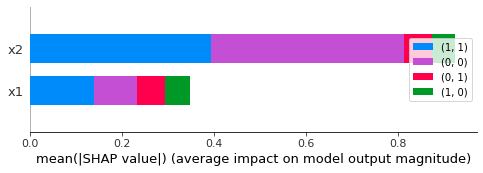

In [21]:
plot_feature_importance_bar(explanations.mclass_diff.labels)

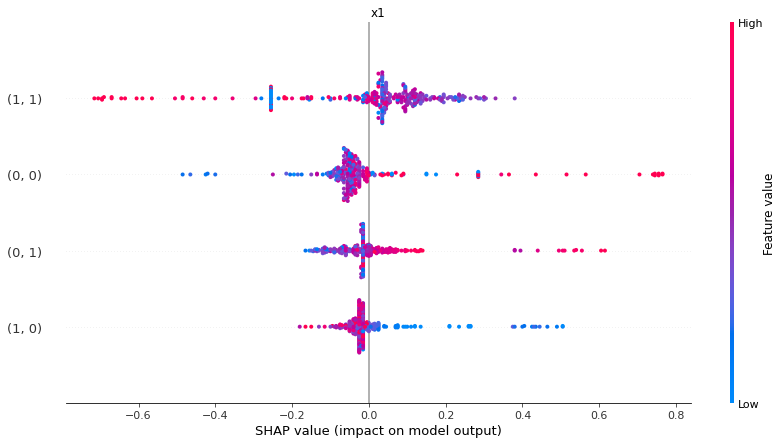

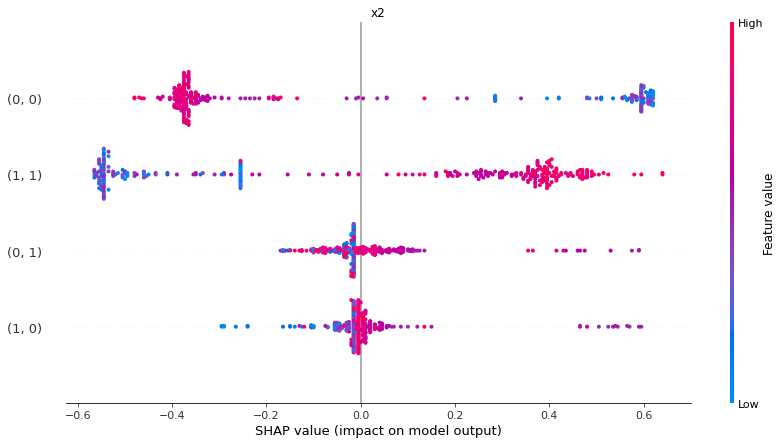

In [22]:
plot_feature_importance_scatter(explanations.mclass_diff.labels)

## Feature effects

### Individual explanations

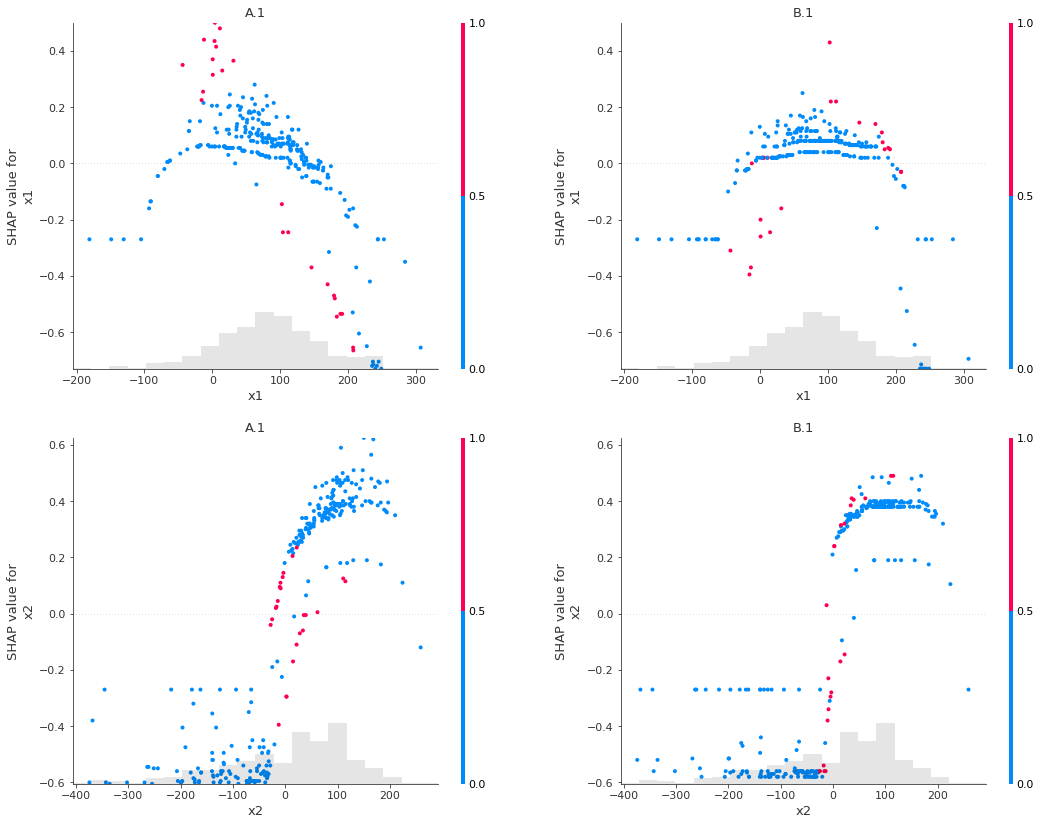

In [23]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
plot_feature_effects(explanations.indiv.labels[:, :, 1].merged, color=is_pred_diff)

### Simple subtraction explanation

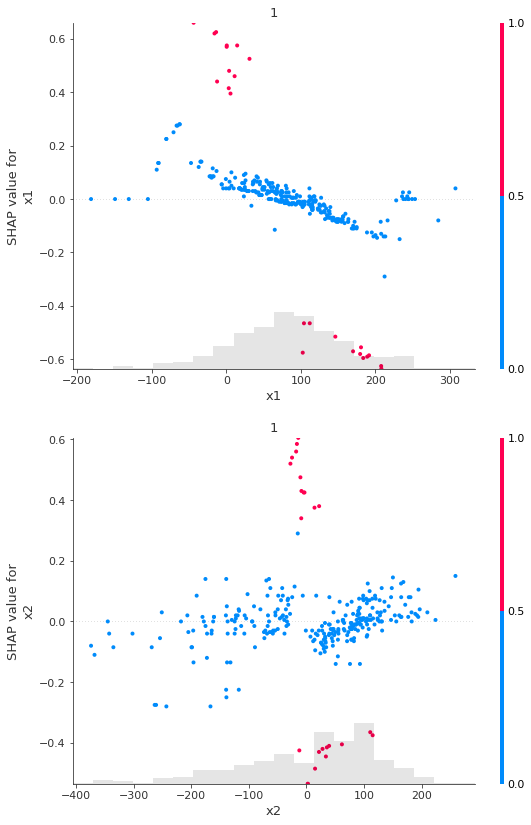

In [24]:
plot_feature_effects(explanations.indiv_diff.labels[:, :, 1], color=is_pred_diff)

### Multiclass difference classifier explanations

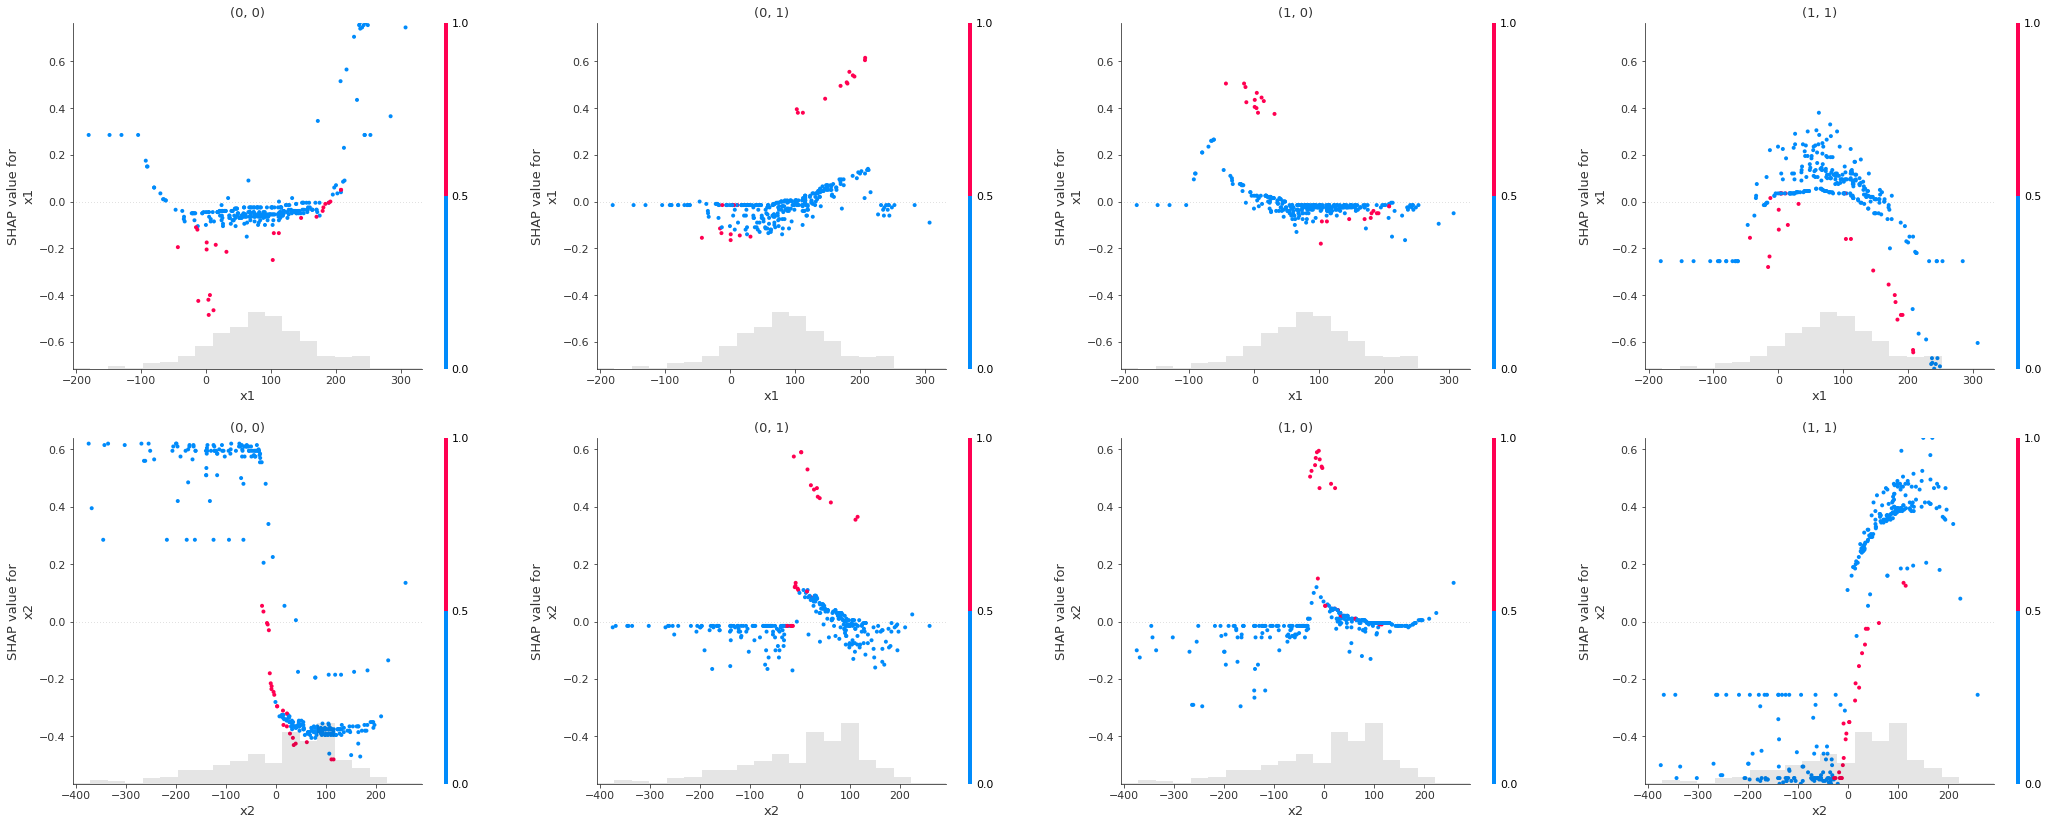

In [25]:
plot_feature_effects(explanations.mclass_diff.labels, color=is_pred_diff)

## Cluster instances

### Individual explanations

In [26]:
instance_order = calc_instance_order(explanations.merged)
plot_forces(explanations.indiv.labels[:, :, 1].merged, instance_order=instance_order)

### Simple subtraction explanation

In [27]:
plot_forces(explanations.indiv_diff.labels, instance_order=instance_order)

### Multiclass difference classifier explanations

In [28]:
plot_forces(explanations.mclass_diff.labels[:, :, comparer.difference_class_names], instance_order=instance_order)

In [6]:
from explainers import merge_explanations, ensure_shap_values_are_3d
from shap.utils import hclust_ordering
import scipy as sp

In [138]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff_proba = comparer.predict_mclass_diff_proba(explanations.data)

In [171]:
explanations_pred_diff_inst = explanations[is_pred_diff]
explanations_pred_equal_inst = explanations[~is_pred_diff]
shap_values = explanations_pred_diff_inst.mclass_diff.log_odds[:, :, comparer.difference_class_names]
shap_values = ensure_shap_values_are_3d(shap_values)
values = shap_values.values.reshape(
    (shap_values.values.shape[0],
     shap_values.values.shape[1] * shap_values.values.shape[2]))
results = comparer.predict_mclass_diff_one_hot(shap_values.data)
values = np.concatenate([values], axis=1)
metric = 'sqeuclidean'
D = sp.spatial.distance.pdist(values, metric)
Z = sp.cluster.hierarchy.complete(D)
Z_ordered = sp.cluster.hierarchy.optimal_leaf_ordering(Z, D)
Z_ordered_indices = sp.cluster.hierarchy.leaves_list(Z_ordered)
instance_order = np.argsort(Z_ordered_indices)

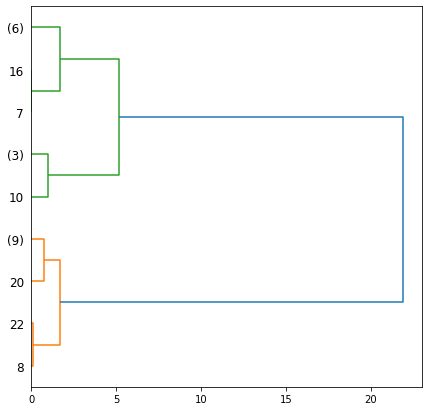

In [140]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', truncate_mode='level', p=2, ax=ax);

In [166]:
n_clusters = 2
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')

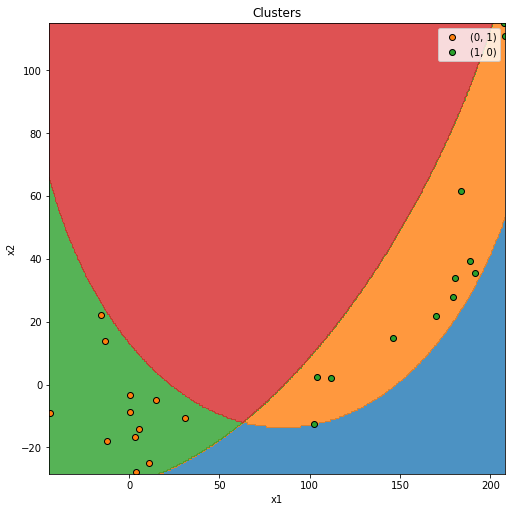

In [167]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
colors = clustering
names = comparer.class_names
plot_decision_boundary(explanations_pred_diff_inst.data, colors, f'Clusters', feature_names,
                       predict=comparer.predict_mclass_diff, class_names=comparer.class_names, fig=fig, ax=ax)

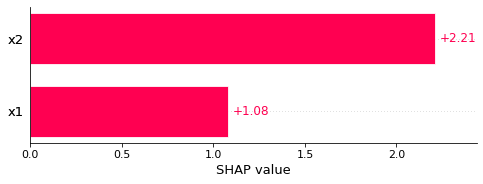

In [154]:
feature_order, feature_importance = calc_feature_order(shap_values)
plot_feature_importance_bar(feature_importance)

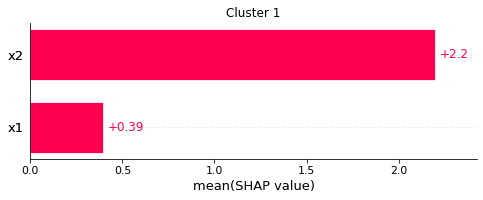

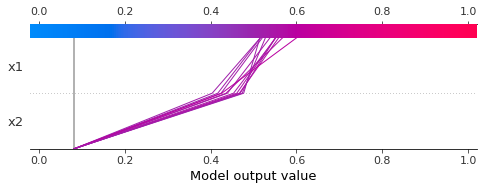

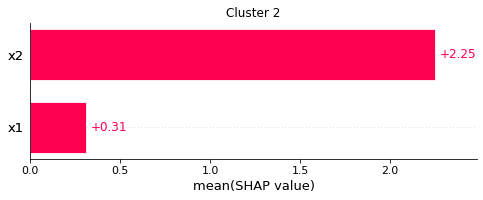

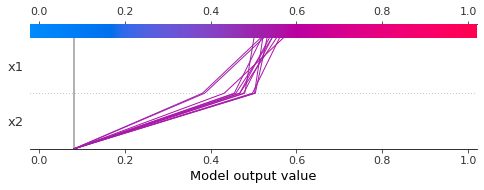

In [157]:
for cluster in np.unique(clustering):
    mask = clustering == cluster
    shap_values = explanations_pred_diff_inst.bin_diff.log_odds[:, :][mask]
    title = f'Cluster {cluster}'
    plot_feature_importance_bar(shap_values.mean(0), title, feature_order=feature_order)
    shap.decision_plot(shap_values.base_values[0], shap_values.values, features=shap_values.data,
                       feature_names=shap_values.feature_names, feature_order=feature_order,
                       link='logit')
    plot_forces(shap_values, title, link='logit')

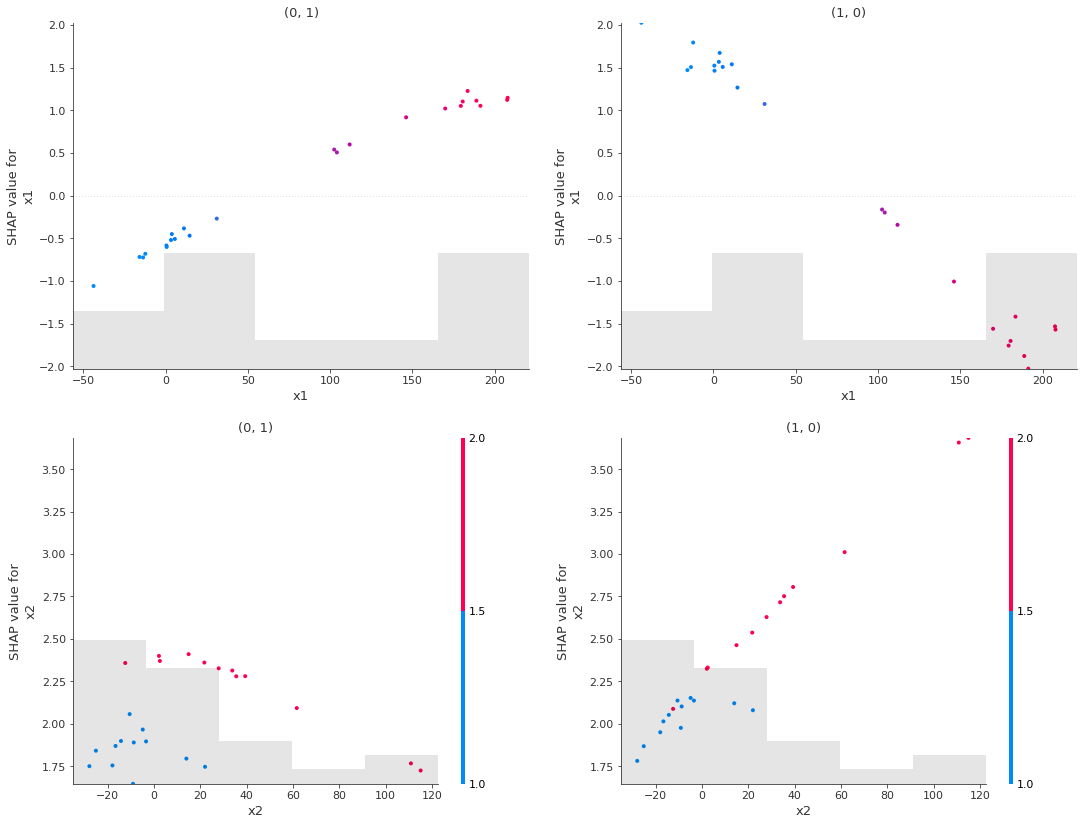

In [162]:
plot_feature_effects(explanations_pred_diff_inst.mclass_diff.log_odds[:, :, comparer.difference_class_names], color=clustering)

In [172]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [173]:
X_im = np.concatenate([explanations_pred_diff_inst.data, explanations_pred_equal_inst.data], axis=0)
y_im = np.concatenate([clustering, np.repeat(0, explanations_pred_equal_inst.shape[0])], axis=0)

In [180]:
tree_interpretable = DecisionTreeClassifier(max_depth=4)
tree_interpretable.fit(X_im, y_im)

DecisionTreeClassifier(max_depth=4)

[Text(661.0153846153847, 342.46799999999996, 'x1 <= 15.871\ngini = 0.15\nsamples = 300\nvalue = [276, 12, 12]\nclass = A'),
 Text(240.3692307692308, 266.364, 'x2 <= -43.185\ngini = 0.343\nsamples = 50\nvalue = [39, 11, 0]\nclass = A'),
 Text(120.1846153846154, 190.26, 'gini = 0.0\nsamples = 29\nvalue = [29, 0, 0]\nclass = A'),
 Text(360.55384615384617, 190.26, 'x2 <= 23.138\ngini = 0.499\nsamples = 21\nvalue = [10, 11, 0]\nclass = B'),
 Text(240.3692307692308, 114.156, 'gini = 0.0\nsamples = 11\nvalue = [0, 11, 0]\nclass = B'),
 Text(480.7384615384616, 114.156, 'gini = 0.0\nsamples = 10\nvalue = [10, 0, 0]\nclass = A'),
 Text(1081.6615384615386, 266.364, 'x1 <= 169.883\ngini = 0.099\nsamples = 250\nvalue = [237, 1, 12]\nclass = A'),
 Text(841.2923076923078, 190.26, 'x2 <= 15.04\ngini = 0.046\nsamples = 212\nvalue = [207, 1, 4]\nclass = A'),
 Text(721.1076923076923, 114.156, 'x2 <= -16.547\ngini = 0.126\nsamples = 75\nvalue = [70, 1, 4]\nclass = A'),
 Text(600.923076923077, 38.051999999

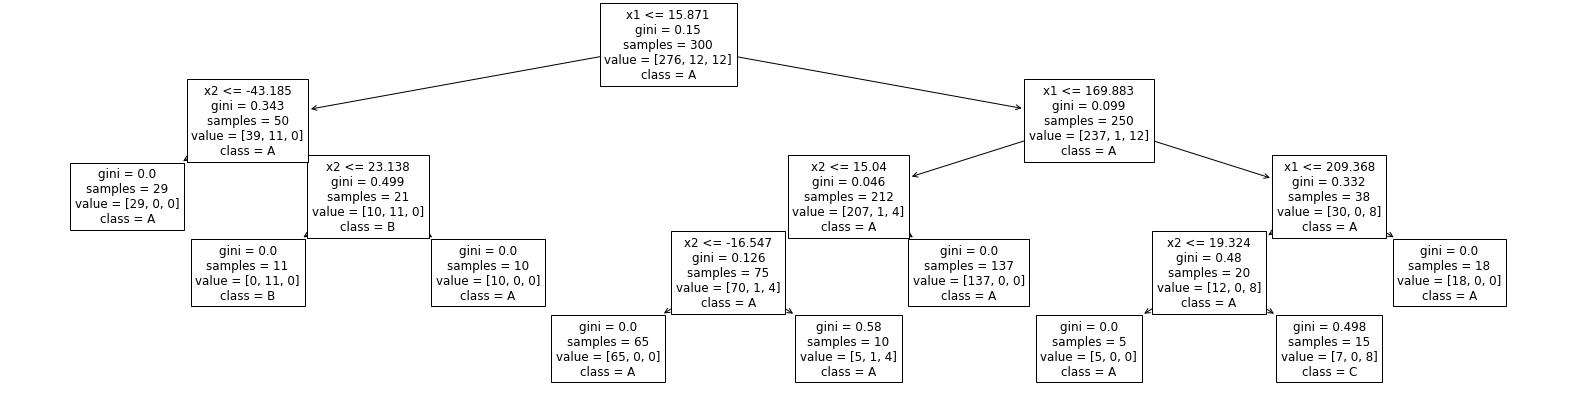

In [182]:
fig, ax = plt.subplots(figsize=(28, 7))
plot_tree(tree_interpretable, feature_names=feature_names, class_names=['A', 'B', 'C'], ax=ax)